In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving driver_ids.csv to driver_ids.csv
Saving ride_ids.csv to ride_ids.csv
Saving ride_timestamps.csv to ride_timestamps.csv


# **Loading Data**

In [0]:
drivers = pd.read_csv('driver_ids.csv',parse_dates= [1])
ride_ids = pd.read_csv('ride_ids.csv')
ride_time = pd.read_csv('ride_timestamps.csv',parse_dates=[1])

In [4]:
# quick review on the structure of tables
for df in [drivers,ride_ids,ride_time]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 2 columns):
driver_id              937 non-null object
driver_onboard_date    937 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 14.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 5 columns):
driver_id          193502 non-null object
ride_id            193502 non-null object
ride_distance      193502 non-null int64
ride_duration      193502 non-null int64
ride_prime_time    193502 non-null int64
dtypes: int64(3), object(2)
memory usage: 7.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194081 entries, 0 to 194080
Data columns (total 2 columns):
ride_id              194081 non-null object
ride_picked_up_at    194081 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 3.0+ MB
None


In [5]:
for df in [drivers,ride_ids,ride_time]:
    print(df.describe())

                               driver_id  driver_onboard_date
count                                937                  937
unique                               937                   49
top     be22fe5992cb9557d7748113ea1f6057  2016-04-05 00:00:00
freq                                   1                   36
first                                NaN  2016-03-28 00:00:00
last                                 NaN  2016-05-15 00:00:00
       ride_distance  ride_duration  ride_prime_time
count  193502.000000  193502.000000    193502.000000
mean     6955.218266     858.966099        17.305893
std      8929.444606     571.375818        30.825800
min        -2.000000       2.000000         0.000000
25%      2459.000000     491.000000         0.000000
50%      4015.000000     727.000000         0.000000
75%      7193.000000    1069.000000        25.000000
max    724679.000000   28204.000000       500.000000
                                 ride_id    ride_picked_up_at
count                      

*This information tells us a fixed time period was given between 03-28-2016 and 06-27-2016 when we do the following anlysis*

# **Data Sanity Check**

In [6]:
## To see if there're duplicated driver_id or ride_id
drivers.driver_id.nunique() == drivers.shape[0]
ride_time.ride_id.nunique() == ride_time.shape[0]

True

In [7]:
## To see how much proportion of drivers have the recorded riding information
print( ride_ids.driver_id.nunique()/len(drivers) *100 )

100.0


In [8]:
## average rides per driver
print(len(ride_ids)/ride_ids.driver_id.nunique() )

206.51227321237994


# **Data Analysis**
## **Define Driver Churn Rate**

In [0]:
## Merger three tables together
driver_ride = pd.merge(pd.merge(ride_ids,drivers,on= 'driver_id'),ride_time,on= 'ride_id')

In [10]:
driver_ride.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,ride_picked_up_at
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,2016-03-29,2016-04-23 02:16:40
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2016-03-29,2016-03-29 19:04:01
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2016-03-29,2016-06-21 12:01:35
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,2016-03-29,2016-05-19 09:18:20
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2016-03-29,2016-04-20 22:07:02


In [0]:
## To see how many drivers disappeared after their first time onboard riding 
 display(driver_ride['driver_id'].value_counts())

5ccc0e6dc9c7475caf785cdce7b8eb7a    919
4eb382d1f7d50fae1294964263d1ce82    831
844e9be5a30d8d9c1f8e9ddb086ff717    821
689bdf87fb2de49f98bf4946cfaa5068    794
3788dc9e91f1548816ce8b5af07ddadc    783
                                   ... 
fd831ca1d79ae5c6fc3a679a22e5b8cf     19
d31eded9263eab43f614eecc6a52a0f5     19
6df6c8f8d3c2a93314245a604c02bed1     16
7b625f643d0775f0ac4898e33235377b      3
7ff85c5c0e9324e28d1e0d0589c364bd      3
Name: driver_id, Length: 837, dtype: int64

*From the above information, we can see that the least number ride for a drver is 3, which means that no drver was churned in the given time period between 2016-03-28 and 2016-06-27 given defination of churned drivers. It leads to no benefit for the business study, therefore, we need to redefine a churned driver as the one has less than 10 ridings within one month interval which will be justified below and apply into future research on the impact to the business.*

In [0]:
## add pick_up month variable and to see how many drivers tends to be churned 
driver_ride['ride_month'] = driver_ride['ride_picked_up_at'].apply(lambda x : x.month)


In [0]:
ride_by_month = driver_ride.groupby('driver_id')['ride_month'].value_counts().unstack().fillna(0)

In [19]:
ride_by_month.info()

<class 'pandas.core.frame.DataFrame'>
Index: 837 entries, 002be0ffdc997bd5c50703158b7c2491 to ffff51a71f2f185ec5e97d59dbcd7a78
Data columns (total 4 columns):
3    837 non-null float64
4    837 non-null float64
5    837 non-null float64
6    837 non-null float64
dtypes: float64(4)
memory usage: 32.7+ KB


In [0]:
## Learn the distribution of month where drivers firstly onboard date
## driver_ride['driver_onboard_date'].unique()

In [0]:
driver_churned= ride_by_month.loc[(ride_by_month[4]<ride_by_month[3]) |
                  (ride_by_month[5]<ride_by_month[3]) | 
                  (ride_by_month[6]<ride_by_month[3]) ]

In [39]:
driver_churned.head()

ride_month,3,4,5,6
driver_id,,,,
02e440f6c209206375833cef02e0cbae,2.0,45.0,9.0,0.0
0938ed763cb3129ae63607aaf69daff5,9.0,16.0,9.0,4.0
0eff1404b137a5562642f0f706e59f25,3.0,42.0,0.0,0.0
1110d496149d3d8c50276765924df831,2.0,26.0,0.0,0.0
173a168d2b8830525f59be85a35f0000,34.0,4.0,0.0,0.0


In [0]:
## Mark if a driver is churned or not 
driver_ride['churned'] = driver_ride.driver_id.apply(lambda x: 1 if x in driver_churned.index else 0)

In [41]:
driver_ride.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,ride_picked_up_at,ride_month,churned
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,2016-03-29,2016-04-23 02:16:40,4,0
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2016-03-29,2016-03-29 19:04:01,3,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2016-03-29,2016-06-21 12:01:35,6,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,2016-03-29,2016-05-19 09:18:20,5,0
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2016-03-29,2016-04-20 22:07:02,4,0


In [49]:
driver_ride.groupby('churned')['driver_id'].nunique()

churned
0    797
1     40
Name: driver_id, dtype: int64

Summary: Finally we consider these drivers who have continuously decreasing ride as churned one marked with 1 for analysis.
The churn rate in the three-month interval is around 5% which is reasonable according to the survey showing that the average monthly churn rate for the industry is 12%. 

## **Assessment on Business Impact**

Text(0, 0.5, 'Count of transaction')

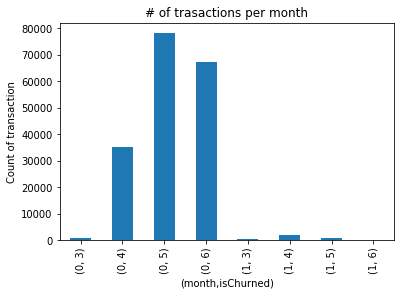

In [44]:
ax = driver_ride.groupby(['churned','ride_month']).size().plot(kind="bar")
ax.set_title("# of trasactions per month")
ax.set_xlabel("(month,isChurned)")
ax.set_ylabel("Count of transaction")

In [71]:
display (driver_ride.groupby(['churned'])['ride_distance'].agg('sum'))
distance_churned = driver_ride[driver_ride['churned']==1]['ride_distance'].agg('sum')
avg_distance_by_driver = driver_ride['ride_distance'].sum()/driver_ride['driver_id'].nunique()

print ("# of new drivers to cover these distance :", round(distance_churned/avg_distance_by_driver,0))

churned
0    1258978643
1      20389159
Name: ride_distance, dtype: int64

# of new drivers to cover these distance : 13.0


In [69]:
display(driver_ride.groupby(['churned'])['ride_duration'].agg('sum'))

duration_churned = driver_ride[driver_ride['churned']==1]['ride_duration'].agg('sum')
avg_duration_by_driver = driver_ride['ride_duration'].sum()/driver_ride['driver_id'].nunique()

print ("# of new drivers to cover these duration:", round(duration_churned/avg_duration_by_driver,0))

churned
0    155790981
1      2605234
Name: ride_duration, dtype: int64

# of new drivers to cover these duration: 14.0


The impact of churned drivers to the business is:
1. These churned drivers lead to the ride distance deccreasing at 20B in distance, and 2M ride minutes in three month, which means the company has to enroll another 13 driver to cover it.
2. The loss would cause understaffed in drivers, that woudl also cause low capacity to meet the demand on market which risking weakening competitiveness.
3. Low capacity of riding would result in dissatisfaction of customers who will give a lower rate on the product.
4. Disatisfied customer might give a lower rate on the other drivers who spend longer time to pick up, this would continuous lead to low performance and dissatisfaction of current drivers. 

## Factors to affect churn

In [74]:
display (driver_ride[driver_ride['churned']==1]['ride_duration'].agg('mean'))
display (driver_ride[driver_ride['churned']==0]['ride_duration'].agg('mean'))

821.5812046672974

860.5429854505684

In [75]:
display (driver_ride[driver_ride['churned']==1]['ride_distance'].agg('mean'))
display (driver_ride[driver_ride['churned']==0]['ride_distance'].agg('mean'))

6429.883002207505

6954.223107855809

In [79]:
display (driver_ride[driver_ride['churned']==1]['ride_prime_time'].agg('mean'))
display (driver_ride[driver_ride['churned']==0]['ride_prime_time'].agg('mean'))

12.62220119836014

17.457108452369116

Among the factors of distance, duration and prime time, it's obvious to see that the prime time of these churned drivers are 40% lower than those not churned , while the ride duration and distance don't differ significantly.

In [0]:
driver_ride['onboard_week'] = driver_ride['driver_onboard_date'].apply(lambda x: x.week)

Text(0, 0.5, 'Count of transaction')

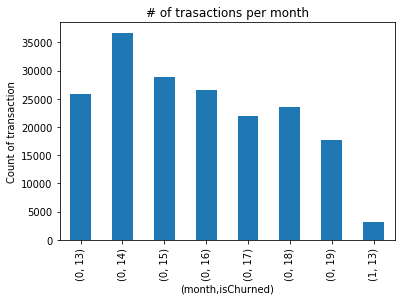

In [81]:
ax = driver_ride.groupby(['churned','onboard_week']).size().plot(kind="bar")
ax.set_title("# of trasactions per month")
ax.set_xlabel("(month,isChurned)")
ax.set_ylabel("Count of transaction")

It tells that these churned drives took on board in the week 13 , which should be dived into further.

In [86]:
display (driver_ride[(driver_ride['churned']==1) & (driver_ride['onboard_week']==13)]['ride_duration'].agg('mean'))
display (driver_ride[(driver_ride['churned']==0) & (driver_ride['onboard_week']==13)]['ride_duration'].agg('mean'))

821.5812046672974

860.8261004580389

In [87]:
display (driver_ride[(driver_ride['churned']==1) & (driver_ride['onboard_week']==13)]['ride_distance'].agg('mean'))
display (driver_ride[(driver_ride['churned']==0) & (driver_ride['onboard_week']==13)]['ride_distance'].agg('mean'))

6429.883002207505

7156.5687834795435

In [88]:
display (driver_ride[(driver_ride['churned']==1) & (driver_ride['onboard_week']==13)]['ride_prime_time'].agg('mean'))
display (driver_ride[(driver_ride['churned']==0) & (driver_ride['onboard_week']==13)]['ride_prime_time'].agg('mean'))

12.62220119836014

15.475312475739461

1. After diving into the distance, duration and prime time compared to the one in entire three months, we can see that the prime time for those churned drived keep the same till the end of June, while it's been increased from 15.5 t0 17.5 fro others.
2. We also can conclude that prime time takes a large propartion on their income , otherwise they would not leave.

 # **Hypotheses to Reduce Churn**

In [89]:
driver_ride[driver_ride['onboard_week']==13].driver_onboard_date

0        2016-03-29
1        2016-03-29
2        2016-03-29
3        2016-03-29
4        2016-03-29
            ...    
183433   2016-03-28
183434   2016-03-28
183435   2016-03-28
183436   2016-03-28
183437   2016-03-28
Name: driver_onboard_date, Length: 28933, dtype: datetime64[ns]